In [1]:
import os
from dotenv import load_dotenv; load_dotenv()

from tqdm.notebook import tqdm
import pickle
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import json

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from src.helpers import preprocessing as preproc
from src.helpers.postprocessing import from_list_to_string, safe_json_load
from src.helpers.sentiment_analysis import SentimentModel
from src.topol_modeling import TopolModeling as TOPOL
from src.openai_api import OPENAI_CLIENT, OpenAIEmbedding
from src.openai_api import chat_completion as openai_chat_completion
from src.google_ai_api import GGENAI_CLIENT, GoogleAIEmbedding, AdvancedGoogleAIEmbedding
from src.google_ai_api import chat_completion as google_chat_completion

In [2]:
DATA_PATH = os.getenv("DATA_PATH")
OUTPUTS_PATH = os.path.join(os.getenv("OUTPUTS_PATH"), "robustness_checks", "rb1")

DEVICE = torch.device("mps")
STOP_WORDS = list(ENGLISH_STOP_WORDS)
RANDOM_STATE = 42

# Getting data

In [3]:
df = pd.read_pickle(os.path.join(DATA_PATH, "us_fed_speeches.pickle"))
FILES_PREFIX = "us_speeches"

In [4]:
# breakpoint = pd.to_datetime("2007-05-01")

# df["label"] = 1.0
# df.loc[df["date"] <= breakpoint, "label"] = 0

In [5]:
df

date                                               text  label
0   2004-01-03  Ben S Bernanke: Fedspeak\nSpeech by Mr Ben S B...    0.0
1   2004-01-03  Ben S Bernanke: Conducting monetary policy at ...    0.0
2   2004-01-03  Alan Greenspan: Risk and uncertainty in moneta...    0.0
3   2004-01-04  Ben S Bernanke: Monetary policy and the econom...    0.0
4   2004-01-04  Roger W Ferguson, Jr: Lessons from past produc...    0.0
..         ...                                                ...    ...
595 2010-03-25  Ben S Bernanke: Federal Reserve's exit strateg...    1.0
596 2010-03-26  Daniel K Tarullo: Lessons from the crisis stre...    1.0
597 2010-03-26  Kevin Warsh: An ode to independence\nSpeech by...    1.0
598 2010-03-26  Brian P Sack: Dollar asset markets - prospects...    1.0
599 2010-03-31  Elizabeth A Duke: Restoring credit to communit...    1.0

[600 rows x 3 columns]

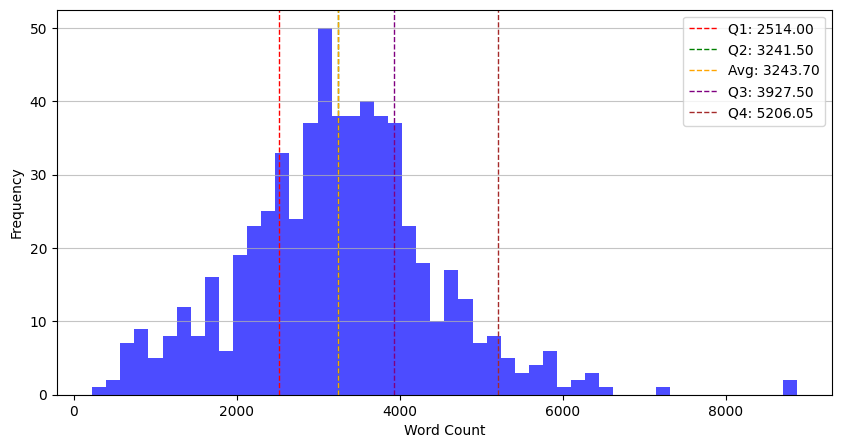

In [6]:
word_counts = df["text"].apply(lambda x: len(x.split()))
q1_word_counts = word_counts.quantile(0.25)
q2_word_counts = word_counts.quantile(0.50)
avg_word_counts = word_counts.mean()
q3_word_counts = word_counts.quantile(0.75)
q4_word_counts = word_counts.quantile(0.95)
plt.figure(figsize=(10, 5))
plt.hist(word_counts, bins=50, color='blue', alpha=0.7)
plt.axvline(q1_word_counts, color='red', linestyle='dashed', linewidth=1, label=f'Q1: {q1_word_counts:.2f}')
plt.axvline(q2_word_counts, color='green', linestyle='dashed', linewidth=1, label=f'Q2: {q2_word_counts:.2f}')
plt.axvline(avg_word_counts, color='orange', linestyle='dashed', linewidth=1, label=f'Avg: {avg_word_counts:.2f}')
plt.axvline(q3_word_counts, color='purple', linestyle='dashed', linewidth=1, label=f'Q3: {q3_word_counts:.2f}')
plt.axvline(q4_word_counts, color='brown', linestyle='dashed', linewidth=1, label=f'Q4: {q4_word_counts:.2f}')
plt.legend()
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

# Pre-processing data

##### 1. Data cleaning

In [7]:
entities_to_mask = ["DATE", "TIME", "ORGANIZATION", "NUM", "LOCATION"]
STOP_WORDS += entities_to_mask

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_texts.pickle")
if os.path.exists(fpath):
    print(f"Loading cleaned texts from {fpath}")
    with open(fpath, "rb") as f:
        texts = pickle.load(f)
    print(f"Loaded {len(texts)} texts")
else:
    print(f"Generating cleaned texts for {len(df)} raw texts...")
    texts = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        cleaned_text = preproc.get_clean_text(row, entities_to_mask=entities_to_mask, max_lenght=5000)
        texts.append(cleaned_text)
    with open(fpath, "wb") as f:
        pickle.dump(texts, f)
    print(f"Saved {len(texts)} cleaned texts to {fpath}.")

df["text"] = texts
del fpath

Loading cleaned texts from /Users/tig1/Programming/TOPOL/data/us_speeches_texts.pickle
Loaded 600 texts


##### 2. Embedding texts

In [8]:
EMBEDDING_MODEL = OpenAIEmbedding(model="text-embedding-3-small")
# EMBEDDING_MODEL = GoogleAIEmbedding(model="text-embedding-004")
# EMBEDDING_MODEL = AdvancedGoogleAIEmbedding(model='text-embedding-004', task='clustering')
# EMBEDDING_MODEL = SentenceTransformer('intfloat/multilingual-e5-large-instruct', device=DEVICE)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_embeddings.pickle")
if os.path.exists(fpath):
    print(f"Loading embeddings from {fpath}")
    with open(fpath, "rb") as f:
        embeddings = pickle.load(f)
    print(f"Loaded {len(embeddings)} embeddings")
else:
    print(f"Generating embeddings for {len(df)} text...")
    embeddings = EMBEDDING_MODEL.encode(df["text"].tolist(), fast=False)
    with open(fpath, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Saved {len(embeddings)} embeddings to {fpath}.")

df["embedding"] = embeddings.tolist()
del fpath

Loading embeddings from /Users/tig1/Programming/TOPOL/data/us_speeches_embeddings.pickle
Loaded 600 embeddings


##### 3.a. Sentiment Analysis: FinBERT

In [9]:
sentiment_model = SentimentModel(model_name="ProsusAI/finbert", device=DEVICE, n_special_tokens=5)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments_finbert.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, truncation=False)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment_finbert"] = sentiments
df["sentiment_score_finbert"] = df["sentiment_finbert"].apply(sentiment_model.get_sentiment_score)
del fpath, sentiment_model

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/us_speeches_sentiments_finbert.pickle
Loaded 600 sentiments


##### 3.b. Sentiment Analysis: Multilingual DistilBERT

In [10]:
sentiment_model = SentimentModel(model_name="tabularisai/multilingual-sentiment-analysis", device=DEVICE, n_special_tokens=5)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments_distilbert.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, truncation=False)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment_distilbert"] = sentiments
df["sentiment_score_distilbert"] = df["sentiment_distilbert"].apply(sentiment_model.get_sentiment_score)
del fpath, sentiment_model

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/us_speeches_sentiments_distilbert.pickle
Loaded 600 sentiments


# TOPOL Modeling

### Prepare data

In [11]:
data_A = df[df["label"] == 1].copy()
data_B = df[df["label"] == 0].copy()

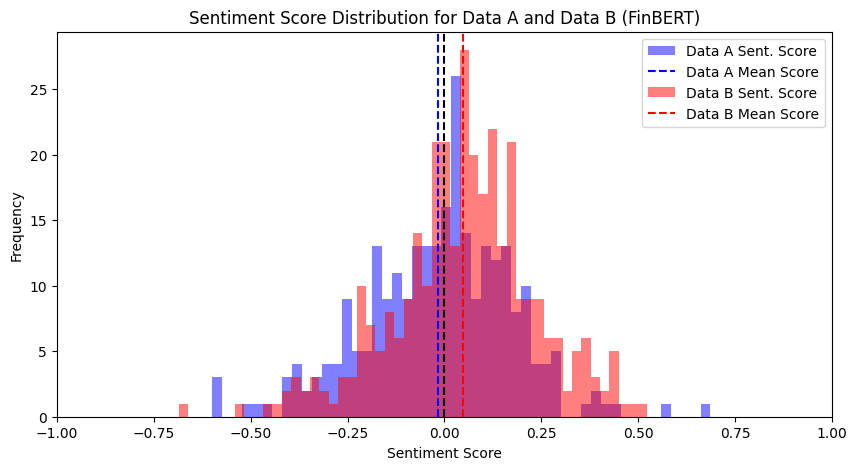

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(data_A["sentiment_score_finbert"].values, bins=50, alpha=0.5, label='Data A Sent. Score', color='blue')
plt.axvline(x=data_A["sentiment_score_finbert"].mean(), color='blue', linestyle='--', label='Data A Mean Score')
plt.hist(data_B["sentiment_score_finbert"].values, bins=50, alpha=0.5, label='Data B Sent. Score', color='red')
plt.axvline(x=data_B["sentiment_score_finbert"].mean(), color='red', linestyle='--', label='Data B Mean Score')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()
plt.title('Sentiment Score Distribution for Data A and Data B (FinBERT)')
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_sentiment_score_finbert_histogram.pdf"), format="pdf", bbox_inches='tight')
plt.show()

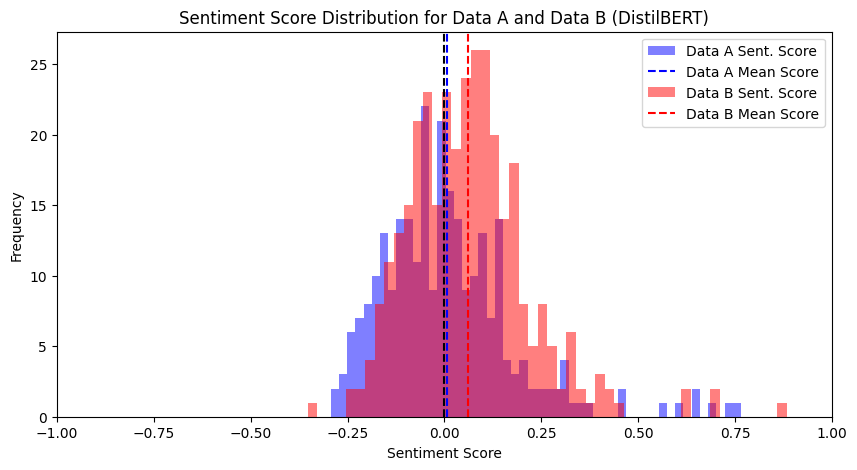

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(data_A["sentiment_score_distilbert"].values, bins=50, alpha=0.5, label='Data A Sent. Score', color='blue')
plt.axvline(x=data_A["sentiment_score_distilbert"].mean(), color='blue', linestyle='--', label='Data A Mean Score')
plt.hist(data_B["sentiment_score_distilbert"].values, bins=50, alpha=0.5, label='Data B Sent. Score', color='red')
plt.axvline(x=data_B["sentiment_score_distilbert"].mean(), color='red', linestyle='--', label='Data B Mean Score')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()
plt.title('Sentiment Score Distribution for Data A and Data B (DistilBERT)')
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_sentiment_score_distilbert_histogram.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Prepare UMAP, Leiden and vectorizer model

In [14]:
umap_params = {
    'n_neighbors': 150, # Change that concerns the robustness check: increasing the number of neighbors
    # 'n_neighbors': 100, --- IGNORE ---
    'min_dist': 0.0,
    'metric': 'cosine',
    'random_state': RANDOM_STATE
}

leiden_params = {
    'resolution': 1.5,
    'modularity': 'dugue',
    'random_state': RANDOM_STATE,
}

vectorizer_model = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(1, 2), max_features=10000)

topol_model = TOPOL(
    n_components=50,
    umap_model_params=umap_params,
    leiden_model_params=leiden_params,
    vectorizer_model=vectorizer_model,
    supervised=False,
)

### TOPOL modeling analysis

In [15]:
topol_model.apply_modeling(
    df_A=data_A,
    df_B=data_B,
    n_top_freq_words=20,
    n_repr_docs=10,
    n_top_tf_idf_words=20
)

/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be r

UMAP applied successfully.
Leiden clustering applied successfully.


/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['date', 'location', 'num', 'organization', 'time'] not in stop_words.
  warnings.warn(


Cluster information extracted successfully.


In [16]:
topol_model.dataset_A.cluster_info

Cluster  Count                                          Top_Words  \
0         0     54  {'financial': 2127, 'risk': 1219, 'date': 989,...   
1         1     39  {'date': 2417, 'inflation': 1891, 'num': 1659,...   
2         2     28  {'date': 1570, 'num': 769, 'financial': 598, '...   
3         3     36  {'date': 1122, 'mortgage': 866, 'num': 821, 'c...   
4         4     31  {'financial': 1272, 'date': 885, 'market': 767...   
5         5     11  {'date': 662, 'num': 473, 'financial': 235, 'e...   
6         6     24  {'federal': 1035, 'reserve': 902, 'date': 873,...   
7         7     21  {'date': 420, 'financial': 399, 'federal': 309...   
8         8     17  {'financial': 535, 'date': 431, 'federal': 297...   
9         9      5  {'small': 362, 'date': 292, 'credit': 237, 'bu...   
10       10      1  {'payments': 84, 'date': 43, 'check': 34, 'res...   

                                             Centroid  \
0   [0.006558993410888231, 0.01610515231732279, 0....   
1   [-0.005914037813244459, 0.003160236513791367, ...   
2   [0.00498330786077921, 0.015288102058028536, 0....   
3   [0.020264476114082046, 0.031787057342525155, 0...   
4   [0.0024341392188122674, 0.02496428202627407, 0...   
5   [-0.0035667028489776635, 0.015906571355034513,...   
6   [-0.01700946582908121, 0.009119897930456014, 0...   
7   [0.009310405867706453, -0.006096075300038571, ...   
8   [0.006440866081153645, 0.00544191970531007, 0....   
9   [-0.010829874873161316, 0.01564342323690653, 0...   
10  [-0.00020456624042708427, -0.01152358390390873...   

                                 2D_Centroid  \
0    [5.405970723540695, -4.085577470284921]   
1    [7.524809715075371, -6.882086925017528]   
2    [6.566775560379028, -7.292630553245544]   
3    [4.557478745778401, -6.407576865620083]   
4   [5.2270711160475205, -5.677886655253749]   
5    [6.757057580080899, -7.266493103720925]   
6     [7.020069658756256, -5.79341588417689]   
7    [7.014295191991897, -5.097724097115653]   
8    [6.096852667191449, -5.106130768271053]   
9   [5.6057721138000485, -7.025324535369873]   
10   [5.138242244720459, -4.690911293029785]   

                              Top_Representative_Docs  \
0   [Ben S Bernanke: Financial regulation and supe...   
1   [Donald L Kohn: Monetary policy research and t...   
2   [Ben S Bernanke: Current economic and financia...   
3   [Randall S Kroszner: Loan modifications and fo...   
4   [Frederic S Mishkin: Global financial turmoil ...   
5   [Randall S Kroszner: The United States in the ...   
6   [Ben S Bernanke: Federal Reserve policies to e...   
7   [Ben S Bernanke: Confirmation hearing Testimon...   
8   [Ben S Bernanke: US financial markets Testimon...   
9   [Frederic S Mishkin: Small business lending Te...   
10  [Randall S Kroszner: The future of payments - ...   

                                      Top_Words_TFIDF  
0   {'financial': 0.5086167934673014, 'federal': 0...  
1   {'date': 0.46392475629894675, 'policy': 0.3906...  
2   {'date': 0.5592249407559793, 'num': 0.22456206...  
3   {'date': 0.38802333213366696, 'mortgage': 0.30...  
4   {'financial': 0.4198762685655915, 'date': 0.31...  
5   {'date': 0.5390877481367233, 'num': 0.37110492...  
6   {'federal': 0.36978128215172706, 'date': 0.313...  
7   {'financial': 0.4119591749940748, 'date': 0.29...  
8   {'financial': 0.4565884145220377, 'date': 0.26...  
9   {'small': 0.4454018804277178, 'date': 0.359274...  
10  {'payments': 0.5328062580441173, 'date': 0.272...

In [17]:
topol_model.dataset_B.cluster_info

Cluster  Count                                          Top_Words  \
0         0     77  {'risk': 2821, 'financial': 1779, 'date': 1623...   
1         1     63  {'date': 2807, 'inflation': 2146, 'policy': 15...   
2         2     66  {'date': 4234, 'num': 2069, 'prices': 1225, 'i...   
3         3     22  {'date': 727, 'num': 469, 'mortgage': 389, 'cr...   
4         4     22  {'risk': 751, 'date': 691, 'credit': 520, 'fin...   
5         5     38  {'date': 1552, 'num': 1147, 'current': 515, 'd...   
6         6     21  {'date': 958, 'reserve': 709, 'federal': 569, ...   
7         7     16  {'date': 340, 'banks': 196, 'num': 167, 'finan...   
8         8      3  {'date': 90, 'bank': 89, 'federal': 76, 'banks...   
9         9      2  {'date': 139, 'community': 67, 'banks': 67, 'c...   
10       10      3  {'payments': 187, 'date': 106, 'check': 99, 'e...   

                                             Centroid  \
0   [0.014372017873052732, 0.021447236226363617, 0...   
1   [-3.0822298001675376e-05, 0.004946478004303427...   
2   [0.010371674890241897, 0.019430212052997598, 0...   
3   [0.03132410924246704, 0.02091565543593209, 0.0...   
4   [0.013531799914992669, 0.01651988048318096, 0....   
5   [0.018887569809234457, 0.016680649473671923, 0...   
6   [-0.00918326551272046, 0.007078757001311585, 0...   
7   [0.017822675421484746, -0.0047858750622253865,...   
8   [0.008718934919064244, 0.001956821729739507, 0...   
9   [0.02056045737117529, 0.027097640559077263, 0....   
10  [0.016722165513783693, 0.0005396887039144834, ...   

                                 2D_Centroid  \
0   [5.158808528602897, -3.8795163414695044]   
1    [7.771322235228523, -7.535551222543868]   
2     [6.375656633666067, -8.12274102008704]   
3     [4.75979203527624, -6.454362793402239]   
4    [5.169277256185358, -5.879554954442111]   
5    [6.516528844833374, -8.191208902158236]   
6    [7.243478275480724, -5.449515524364653]   
7    [6.737844675779343, -5.548276275396347]   
8    [5.080793539683024, -4.380985418955485]   
9   [6.6018993854522705, -5.884718656539917]   
10   [6.989712238311768, -5.541225592295329]   

                              Top_Representative_Docs  \
0   [Susan Schmidt Bies: A US supervisor's perspec...   
1   [Alan Greenspan: Jackson Hole Conference - ref...   
2   [Mark W Olson: Update on the US economy Remark...   
3   [Ben S Bernanke: Community development financi...   
4   [Timothy F Geithner: Perspectives on the US fi...   
5   [Alan Greenspan: Euro in wider circles Remarks...   
6   [Donald L Kohn: Regulatory reform proposals Re...   
7   [Alan Greenspan: Nomination hearing Testimony ...   
8   [Mark W Olson: Perspectives on the development...   
9   [Kevin M Warsh: Corporate cash balances and ec...   
10  [Alan Greenspan: The payments system in transi...   

                                      Top_Words_TFIDF  
0   {'risk': 0.4261487034393744, 'basel': 0.337789...  
1   {'inflation': 0.48709361970331794, 'date': 0.4...  
2   {'date': 0.5833138180911217, 'num': 0.30909818...  
3   {'date': 0.36946257819704065, 'data': 0.234762...  
4   {'risk': 0.40571870726868325, 'financial': 0.3...  
5   {'date': 0.3968228328083657, 'num': 0.27542972...  
6   {'date': 0.38224479835432745, 'reserve': 0.370...  
7   {'date': 0.40670480036696677, 'financial': 0.3...  
8   {'date': 0.2718223497875164, 'bank': 0.2688021...  
9   {'date': 0.529299859281979, 'community': 0.255...  
10  {'payments': 0.5099746026797415, 'date': 0.289...

Drift computed successfully, ready to vizualize.


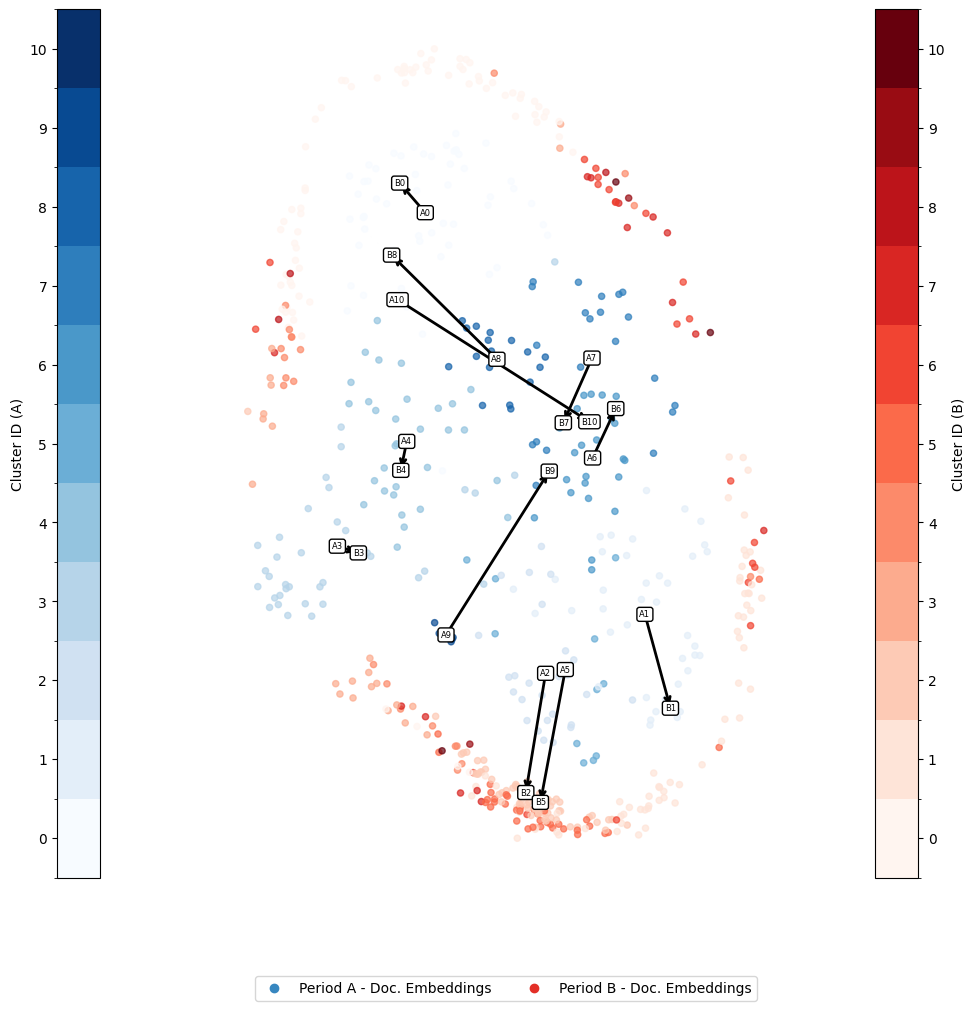

In [18]:
fig, ax = topol_model.vizualize_clusters()
fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_clusters.pdf"), format="pdf", bbox_inches='tight')
plt.show(fig, ax)

### Drift analysis

In [19]:
no_nan_drifts = { k: v for k, v in topol_model.drifts.items() if isinstance(v, np.ndarray) }
drifts_df = pd.DataFrame.from_dict(no_nan_drifts, orient='index', columns=['x', 'y'])
# drifts_df = pd.DataFrame.from_dict(topol_model.drifts, orient='index', columns=['x', 'y']).dropna()
drifts_df.index.name = "Cluster"

In [20]:
# Normalize drift vectors to unit length
unit_drifts = normalize(drifts_df.dropna().values, norm='l2')

k = 4
# # KMeans on unit vectors ≈ angular k-means (cosine similarity)
# kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
# drifts_df["labels"] = kmeans.fit_predict(unit_drifts)

# Compute angles in radians
angles = np.arctan2(unit_drifts[:, 1], unit_drifts[:, 0])   # range [-pi, pi]
angles = (angles + 2 * np.pi) % (2 * np.pi)                 # convert to [0, 2pi]
sector_size = 2 * np.pi / k                                 # Define number of angular sectors
labels = np.floor(angles / sector_size).astype(int)         # Assign each angle to a sector
drifts_df["labels"] = labels

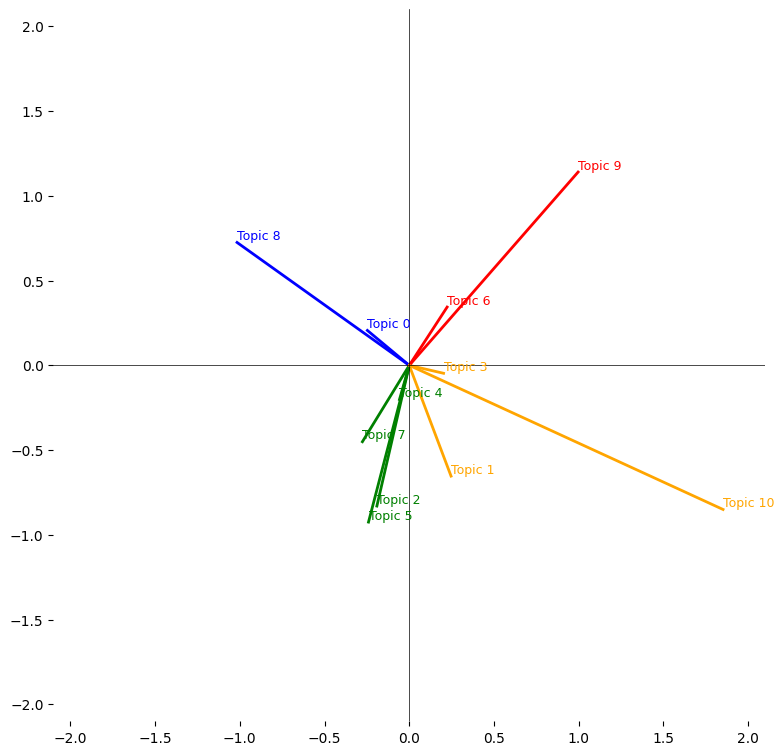

In [21]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray']

fig, ax = plt.subplots(figsize=(8, 10))

for topic_id, row in drifts_df.iterrows():
    x, y, label_id = row['x'], row['y'], int(row['labels'])
    color = colors[label_id]
    ax.plot([0, x], [0, y], color=color, linewidth=2, label=f"Topic {topic_id}")
    ax.text(x, y, f"Topic {topic_id}", fontsize=9, color=color, ha='left', va='bottom')

lim = 2.1
ax.set_aspect('equal', 'box')
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
ax.axhline(0, color='black', linewidth=0.5); ax.axvline(0, color='black', linewidth=0.5)
ax.set_frame_on(False)
fig.tight_layout()

fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_drifts.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Drift explainability

In [22]:
fpath = os.path.join(DATA_PATH, "narrative_dimensions.pickle")
if os.path.exists(fpath):
    with open(fpath, "rb") as f:
        NARRATIVE_DIMENSIONS = pickle.load(f)
    print(f"Loaded {len(NARRATIVE_DIMENSIONS)} narrative dimensions from {fpath}")
else:
    raise FileNotFoundError(f"File {fpath} not found. Please generate narrative dimensions first.")
del fpath

Loaded 123 narrative dimensions from /Users/tig1/Programming/TOPOL/data/narrative_dimensions.pickle


In [23]:
fpath = os.path.join(DATA_PATH, "prompt_template.txt")
if os.path.exists(fpath):
    with open(fpath, "r") as f:
        PROMPT_TEMPLATE = f.read()
    print(f"Loaded prompt template from {fpath}")
else:
    raise FileNotFoundError(f"Prompt template file not found at {fpath}")
del fpath

Loaded prompt template from /Users/tig1/Programming/TOPOL/data/prompt_template.txt


In [24]:
def generate_narrative_comparison_prompt(text1, text2):
    prompt = PROMPT_TEMPLATE.replace("#####DIMENSIONS_LIST#####", from_list_to_string(NARRATIVE_DIMENSIONS))
    prompt = prompt.replace("#####TEXT1#####", text1)
    prompt = prompt.replace("#####TEXT2#####", text2)
    return prompt

In [25]:
# chat_completion_func = openai_chat_completion
chat_completion_func = google_chat_completion

In [26]:
zipped_representative_docs = list(zip(
    topol_model.dataset_A.cluster_info['Top_Representative_Docs'],
    topol_model.dataset_B.cluster_info['Top_Representative_Docs']
))
top_n_docs = 3  # Number of top documents to compare per cluster

for i, (top_docs_A, top_docs_B) in tqdm(enumerate(zipped_representative_docs), total=len(zipped_representative_docs)):

    # Get the representative documents for each cluster
    if top_n_docs is not None:
        text1 = from_list_to_string(top_docs_A[:top_n_docs])  # Take top N docs for cluster A
        text2 = from_list_to_string(top_docs_B[:top_n_docs])  # Take top N docs for cluster B
    else:
        text1 = from_list_to_string(top_docs_A)
        text2 = from_list_to_string(top_docs_B)

    # Generate the prompt for the LLM
    prompt = generate_narrative_comparison_prompt(text1, text2)
    response = chat_completion_func(prompt, max_tokens=1000000)

    # Dynamic response variable (you can also use a list or dict instead of naming each one)
    var_name = f"response_row{i}"
    globals()[var_name] = response

    # Parse the JSON response safely
    parsed_llm_out = safe_json_load(response)

    # Save to file
    with open(f"{OUTPUTS_PATH}/{FILES_PREFIX}_ND_row{i}.json", "w", encoding="utf-8") as f:
        json.dump(parsed_llm_out, f, ensure_ascii=False, indent=2)

    print(f"✅ Processed and saved row {i}")

  0%|          | 0/11 [00:00<?, ?it/s]

Response: ```json
[
  {
    "dimension_title": "Financial Stability vs. Instability",
    "polar_extremes_subtitle": "Financial Instability – Financial Stability",
    "presence": "both",
    "coverage_text1": 40,
    "coverage_text2": 35,
    "difference_confidence": 10,
    "cosine_similarity": 0.85,
    "text1_evidence_sentences": [
      "Not much DATE, we and our international counterparts faced the most severe financial crisis since the Great Depression.",
      "Fortunately, forceful and coordinated policy actions averted a global financial collapse, and since then, aided by a range of government programs, financial conditions have improved considerably.",
      "However, even though we avoided the worst financial and economic outcomes, the fallout from the crisis has nonetheless been very severe, as reflected in the depth of the global recession and the deep declines in employment both here and abroad."
    ],
    "text2_evidence_sentences": [
      "As a central banker, I real